# Detection de faux billets - Projet 6

## Initialisations, import et configuration

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lineaire_functions import *
from acp_functions import *
from sklearn import neighbors, metrics
from sklearn import model_selection
from sklearn.datasets import load_digits
from sklearn import preprocessing, decomposition
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram

In [2]:
data = pd.read_csv('notes.csv', sep=',', decimal='.')

In [3]:
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [4]:
data.shape

(170, 7)

In [5]:
data.loc[data['is_genuine'] == False]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
100,False,171.45,104.03,104.26,4.88,3.44,111.92
101,False,171.97,104.38,104.18,5.59,3.47,110.98
102,False,171.94,104.21,104.10,4.28,3.47,112.23
103,False,172.04,104.34,104.48,4.88,3.28,112.15
104,False,171.75,104.16,104.23,5.75,3.25,111.68
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


In [6]:
# stockage du nombre d'individus
data_rows = data.shape[0]

In [7]:
print(pd.isnull(data).sum())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [8]:
data.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [9]:
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


#### Passage Obj -> Float type

In [10]:
for x in data.columns:
    if(data[x].dtype == np.object_):
        data[x] = data[x].astype(float, errors='raise')

In [11]:
data.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [12]:
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [13]:
data["is_genuine"].value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

#### Copie des donnees initiales

In [14]:
data_copy = data.copy()

#### Matrice par paires

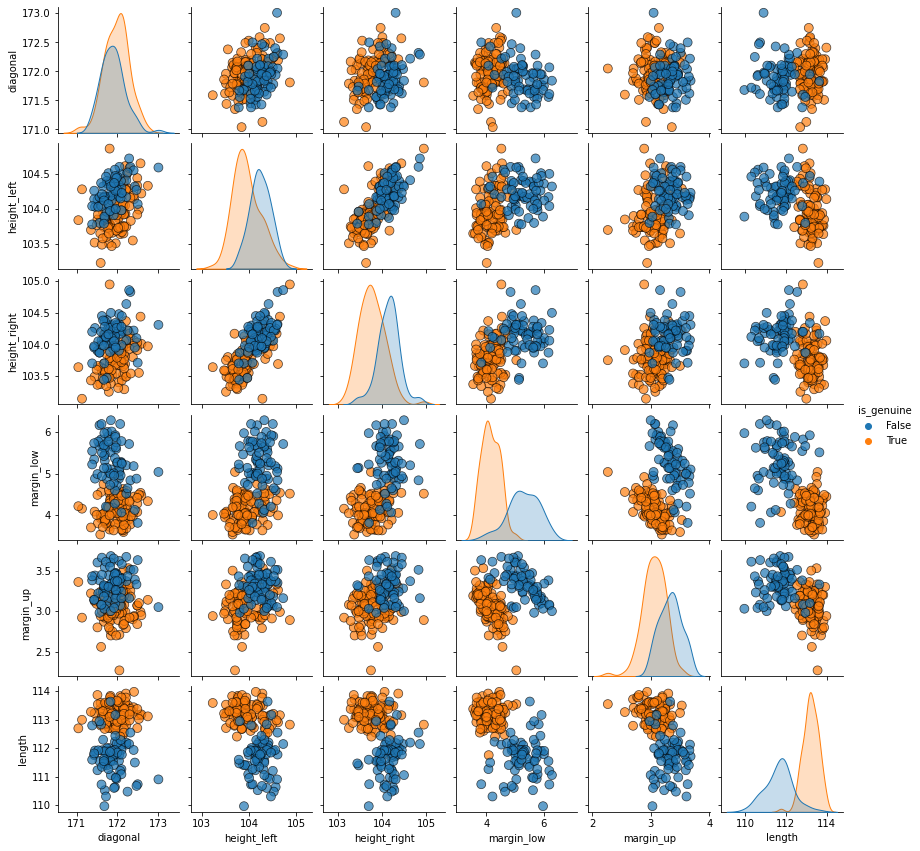

In [15]:
sns.pairplot(data, hue='is_genuine', diag_kind='kde',
             plot_kws={'alpha': 0.7, 's': 80, 'edgecolor': 'k'},
             height=2)

#### Tableau de contingence

<AxesSubplot:>

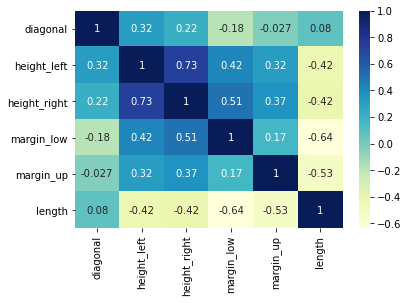

In [16]:
cols = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]
corr_matrix=data[cols].corr()

sns.heatmap(corr_matrix,annot=True, cmap="YlGnBu")

## Premiere methode d'analyse et d'ACP

In [17]:
# On conserve les 6 colonnes qui nous intéressent
select = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

In [18]:
# On normalise la dataset ainsi conservée
dataNorm = data[select]
dataNorm = preprocessing.StandardScaler().fit_transform(dataNorm)

In [19]:
# On vérifie que la normalisation est un succès
print("Moyennes :\n", np.mean(dataNorm, axis = 0)) # Les moyennes devraient valoir 0 ou être infiniment petites avec l'arrondi
print("\nÉcarts-types :\n", np.std(dataNorm, axis = 0)) # Les écarts-types devraient valoir 1
print("\nMatrice de corrélation :\n", (1/data_rows) * np.matmul(np.transpose(dataNorm), dataNorm)) # La matrice doit avoir des 1 sur la diagonale

Moyennes :
 [ 7.69580478e-15  3.14728635e-14  3.61958829e-14  7.52339367e-16
 -1.50467873e-15 -1.37510918e-14]

Écarts-types :
 [1. 1. 1. 1. 1. 1.]

Matrice de corrélation :
 [[ 1.          0.3195838   0.22041801 -0.1810204  -0.02736555  0.08029519]
 [ 0.3195838   1.          0.73439027  0.42453003  0.32478764 -0.42138735]
 [ 0.22041801  0.73439027  1.          0.50937524  0.36691788 -0.41702056]
 [-0.1810204   0.42453003  0.50937524  1.          0.17111283 -0.63735169]
 [-0.02736555  0.32478764  0.36691788  0.17111283  1.         -0.52528385]
 [ 0.08029519 -0.42138735 -0.41702056 -0.63735169 -0.52528385  1.        ]]


In [20]:
# ACP bénigne afin d'utiliser ses fonctions de calculus de valeurs propres et variances
acp = decomposition.PCA()
acp.fit_transform(dataNorm)

# Éléments nécessaire au choix du nombre de composantes principales
print("Valeurs propres :\n", acp.explained_variance_)
print("\nQualité de représentation des axes en % :\n", acp.explained_variance_ratio_ * 100)
print("\nQualité cumulée en % :\n", np.cumsum(acp.explained_variance_ratio_) * 100)

Valeurs propres :
 [2.86372065 1.32522178 0.85912514 0.51460481 0.27840703 0.19442354]

Qualité de représentation des axes en % :
 [47.44792058 21.95710596 14.23452433  8.52629544  4.61282244  3.22133125]

Qualité cumulée en % :
 [ 47.44792058  69.40502654  83.63955087  92.16584631  96.77866875
 100.        ]


In [21]:
# On génère ici l'ACP sur laquelle nous allons travailler
n = 4 # Nombre de composantes principales
acp = decomposition.PCA(n)
composantes = acp.fit_transform(dataNorm)

# On affiche les premiers résultats
print("Valeurs propres :\n", acp.explained_variance_) # On rappelle les valeurs propres conservées
print("\nMatrice de changement de base :\n", acp.components_) # La matrice de changement de base, obtenue normalement à partir des vecteurs propres
print("\nComposantes principales :\n", composantes) # Les composantes principales données par la matrice de changement de base
print("\nSomme des composantes :\n", composantes.sum(axis = 0)) # La somme par colonne des composantes principales doit valoir 0

Valeurs propres :
 [2.86372065 1.32522178 0.85912514 0.51460481]

Matrice de changement de base :
 [[ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
 [ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]
 [-0.08889419  0.12276016  0.15383022  0.5128076  -0.82114881  0.12691346]
 [-0.55973158  0.2780463   0.45893794 -0.22652773  0.13533955  0.57370304]]

Composantes principales :
 [[ 2.15363875e+00  1.59970945e+00  1.78745079e+00  2.43346523e+00]
 [-2.11041589e+00 -5.26038920e-01  5.42562773e-01  3.44549507e-01]
 [-1.97315242e+00 -4.81017831e-02  8.58715625e-01  3.74812313e-01]
 [-2.05979509e+00 -8.91052105e-02 -5.31528774e-01  5.19548030e-01]
 [-2.40318009e+00  4.12169775e-01  3.31950717e+00 -8.37042502e-01]
 [ 1.23565611e+00  2.98319112e+00  9.53053866e-01  3.88824135e-01]
 [-2.07941191e+00  1.14797998e+00  1.71244552e-01 -9.61221918e-01]
 [-2.62393408e+00 -1.04013317e+00 -1.06909272e+00  3.58567590e-01]
 [-1.73630901e+00 -2.27630997e-01 -1

In [22]:
# On observe les contributions des individus aux axes
contrib = composantes ** 2
for i in range(n):
    contrib[:,i] = contrib[:,i] / (data_rows * acp.explained_variance_[i])

print("Contribution aux axes :\n", contrib)

Contribution aux axes :
 [[9.52721884e-03 1.13591212e-02 2.18757445e-02 6.76904690e-02]
 [9.14863971e-03 1.22828251e-03 2.01555492e-03 1.35700203e-03]
 [7.99726885e-03 1.02703410e-05 5.04886064e-03 1.60584984e-03]
 [8.71502155e-03 3.52426628e-05 1.93440859e-03 3.08552194e-03]
 [1.18629599e-02 7.54075438e-04 7.54469823e-02 8.00888865e-03]
 [3.13628609e-03 3.95025080e-02 6.21912875e-03 1.72815886e-03]
 [8.88181004e-03 5.84966696e-03 2.00783574e-04 1.05614747e-02]
 [1.41425026e-02 4.80220177e-03 7.82573963e-03 1.46966821e-03]
 [6.19262045e-03 2.29998665e-04 9.00476104e-03 4.67096594e-05]
 [1.08711147e-03 5.02398892e-03 3.40259396e-03 1.46592290e-04]
 [5.04986348e-04 1.34153132e-02 1.58519872e-02 1.21048967e-02]
 [8.97476308e-03 7.70778675e-04 4.54478732e-03 2.75317264e-05]
 [5.27339136e-05 9.08604598e-03 3.10164239e-03 3.71419376e-04]
 [4.68974441e-03 1.22403148e-04 5.76537906e-03 3.04966933e-03]
 [3.17075859e-03 1.60953311e-03 5.22998131e-03 9.45602285e-04]
 [6.31465026e-03 1.12159207e-0

## Representation des individus

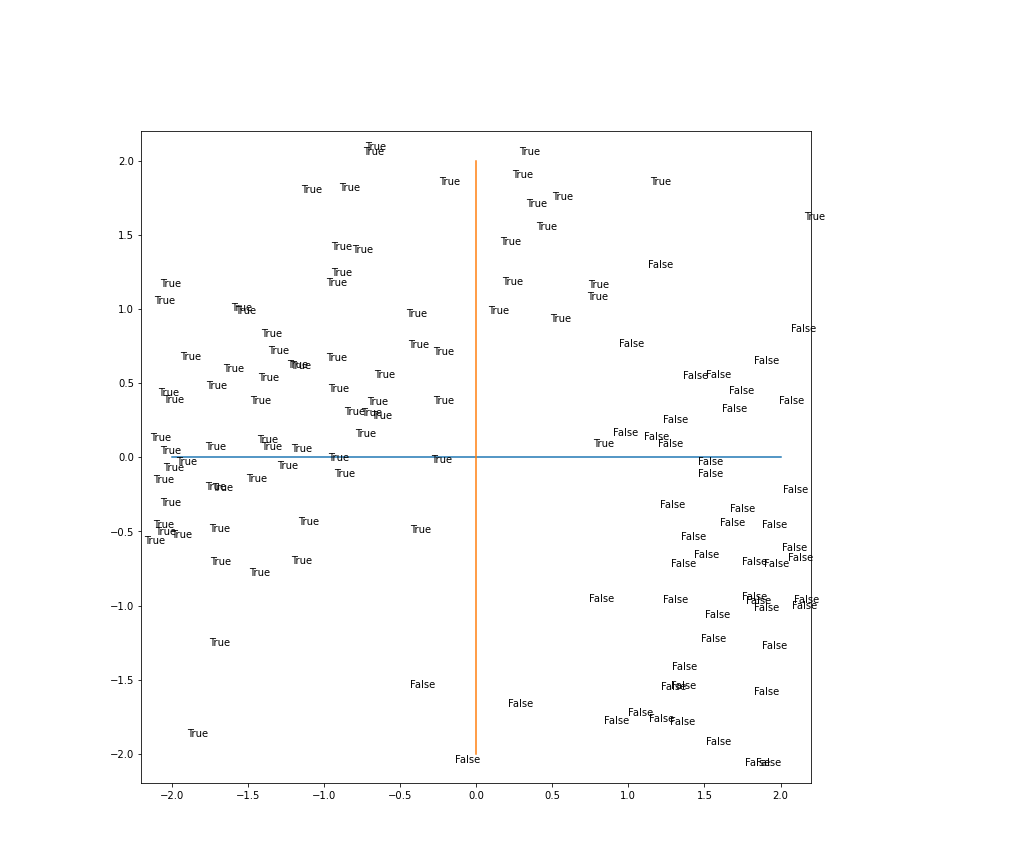

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78
166,173.01,104.59,104.31,5.04,3.05,110.91
167,172.47,104.27,104.10,4.88,3.33,110.68
168,171.82,103.97,103.88,4.73,3.55,111.87


In [23]:
# Création des figures
fig, axes = plt.subplots(figsize=(12, 12))

# Sélectionner l'ensemble des éléments
tmp = pd.DataFrame(columns=list(data))
for i in range(170):
    tmp.loc[i]=data.iloc[i]
    plt.annotate(tmp.loc[i].is_genuine, (composantes[i, 0], composantes[i, 1]))
    
# Échelle des axes
plt.plot([-2,2], [0,0])
plt.plot([0,0], [-2,2])

# Affichage du graphique et du dataset
plt.show()
select2 = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
tmp[select2]

## Representation des variables / Cercles de correlations

In [24]:
# Corrélations variables-facteurs
x = np.sqrt(acp.explained_variance_)
y = np.zeros((len(select), len(select)))
for i in range(n):
    y[:,i] = acp.components_[i,:] * x[i]

print(pd.DataFrame({'Variable':select, 'Composante 1':y[:,0], 'Composante 2':y[:,1]}))

       Variable  Composante 1  Composante 2
0      diagonal      0.124000      0.897507
1   height_left      0.804670      0.390539
2  height_right      0.832286      0.271153
3    margin_low      0.729406     -0.368997
4     margin_up      0.596587     -0.162455
5        length     -0.787529      0.362089


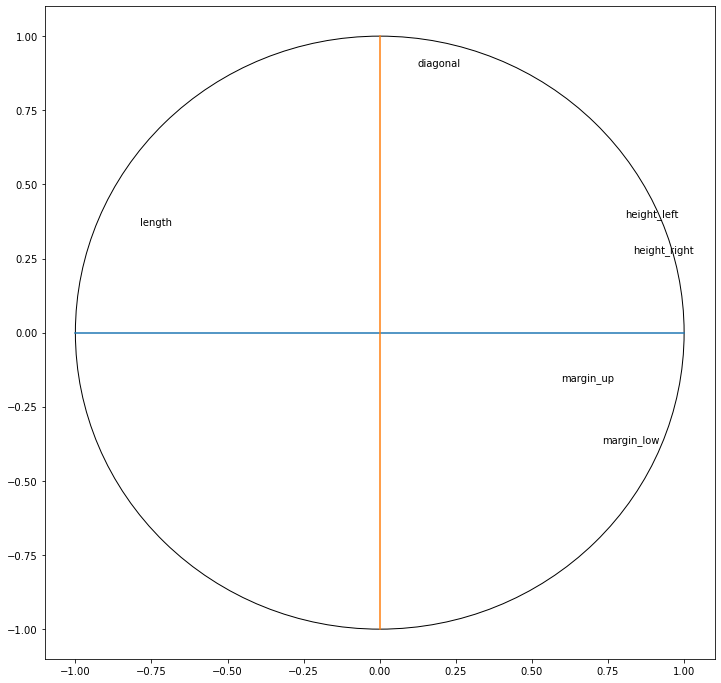

In [25]:
# Création des figures
fig, axes = plt.subplots(figsize=(12,12))

# Récupération des noms
for i in range(len(select)):
    plt.annotate(select[i],(y[i,0], y[i,1]))

# Échelle des axes
plt.plot([-1,1],[0,0])
plt.plot([0,0],[-1,1])

# Ajouter un cercle
cercle = plt.Circle((0,0), 1, fill=False)
axes.add_artist(cercle)

# Affichage du cercle
plt.show()

## Deuxieme methode

## Analyse en Composantes Principales

In [26]:
#Initialisation nombre de composantes
n_comp = 4

#Initialisation d'une var contenant les colonnes principales
data_acp = data[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

#Initialisation des donnees pour l'ACP
data_acp = data_acp.fillna(data_acp.mean())
X = data_acp.values

#Recuperation des ID
names = data.index
features = data.columns[1:]

#Centrage et reduction des donnees
X_scaled = preprocessing.StandardScaler().fit_transform(X)

#Calcul des composantes principales
acp = decomposition.PCA(svd_solver='full', n_components=n_comp)
acp.fit(X_scaled)

PCA(n_components=4, svd_solver='full')

#### Eboulis des valeurs propres

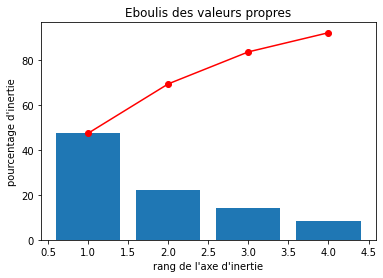

[0.47447921 0.21957106 0.14234524 0.08526295]


In [27]:
display_scree_plot(acp)

# Proportion de variance expliquée
print(acp.explained_variance_ratio_)

- Les 4 premieres composantes sont suffisantes (Plans factoriel F1&F2)
- Composantes 1&2 > 65% de l'inertie totale

#### Cercle des correlations / methode ++ 

In [28]:
from acp_functions import *
pcs = get_correlation(acp, X_scaled)

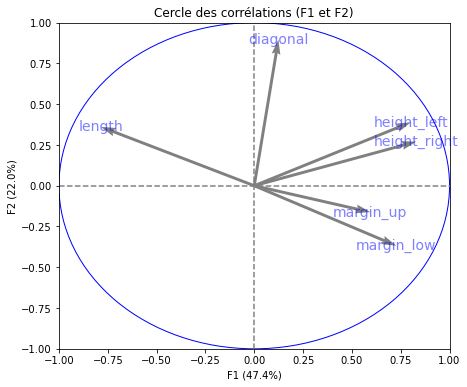

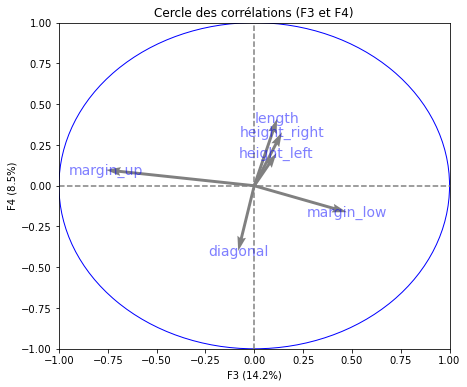

In [29]:
display_circles(pcs, n_comp, acp, [(0,1),(2,3)], labels = np.array(features))

In [30]:
#Composante 1
f1 = acp.components_[0]
for i, feature in zip(features, f1):
    print(f"{i} : {feature}")

diagonal : 0.07327499450017279
height_left : 0.47550205158067943
height_right : 0.4918214040200751
margin_low : 0.4310267113776865
margin_up : 0.3525398409189687
length : -0.46537287771748287


In [31]:
#Composante 2
f2 = acp.components_[1]
for i, feature in zip(features, f2):
    print(f"{i} : {feature}")

diagonal : 0.7796390848539915
height_left : 0.3392501905596284
height_right : 0.23554253027060038
margin_low : -0.3205369869202691
margin_up : -0.1411197424006689
length : 0.31453645309860884


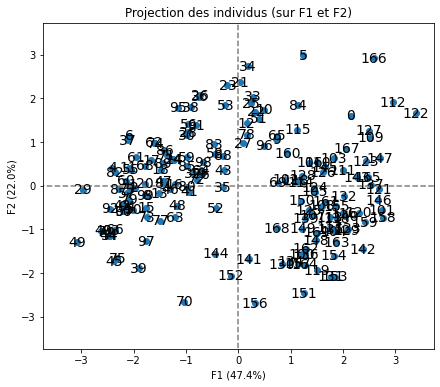

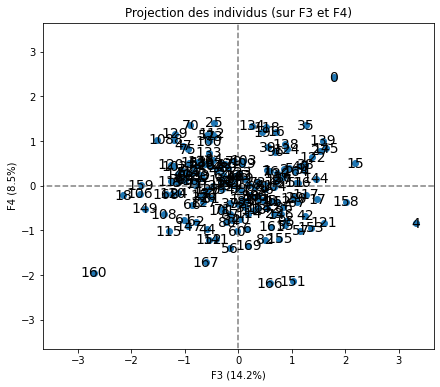

In [32]:
# Projection des individus
X_projected = acp.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, acp, [(0,1),(2,3)], labels = np.array(names))

plt.show()

#### Projection des individus True /False

In [33]:
X_projected = acp.transform(X_scaled)

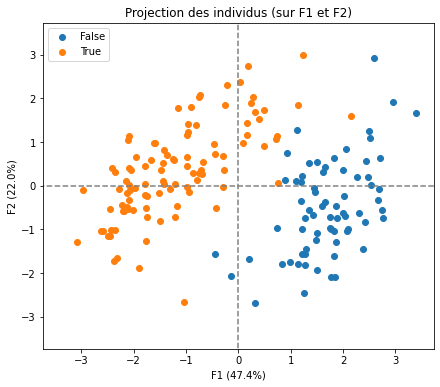

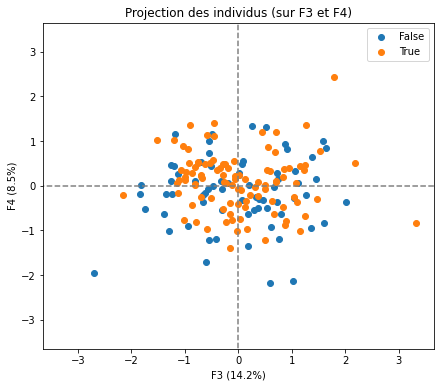

In [34]:
display_factorial_planes(X_projected, n_comp, acp, [(0,1),(2,3)], labels=None, illustrative_var=data["is_genuine"])

## Contribution des individus dans l'inertie totale

In [35]:
di = np.sum(X_scaled**2,axis=1)

ctr_indiv_inertie = pd.DataFrame(di, index=data.index, columns=['d_i'])

ctr_indiv_inertie.head(10)

,d_i
0,18.410598
1,5.444799
2,4.960527
3,4.805719
4,18.039567
5,11.527985
6,8.029025
7,9.344338
8,5.961640
9,2.373650


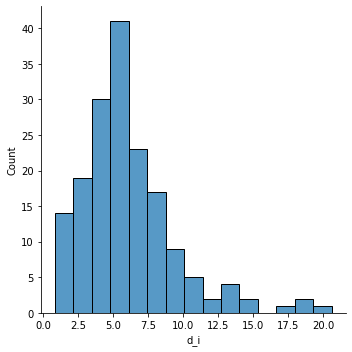

In [36]:
sns.displot(ctr_indiv_inertie["d_i"])

## Qualité de représentation des individus - COS2

In [37]:
cos2 = X_projected**2

for j in range(n_comp):
    cos2[:,j] = cos2[:,j]/di
    
cos2_indiv = pd.DataFrame(cos2, index=data.index,
                          columns=['COS2_'+str(i + 1) for i in range(n_comp)])
    
cos2_indiv.head(10)

,COS2_1,COS2_2,COS2_3,COS2_4
0,0.251929,0.139000,0.173540,0.321649
1,0.818002,0.050822,0.054065,0.021803
2,0.784862,0.000466,0.148652,0.028320
3,0.882856,0.001652,0.058789,0.056169
4,0.320145,0.009417,0.610831,0.038839
5,0.132447,0.771985,0.078792,0.013115
6,0.538540,0.164137,0.003652,0.115076
7,0.736813,0.115779,0.122316,0.013759
8,0.505695,0.008692,0.220603,0.000685
9,0.222965,0.476836,0.209362,0.005403


## Ajout des plans facto au tableau de donnees

In [38]:
data_fn = pd.DataFrame(X_projected, index=data.index,columns=["F"+str(i+1) for i in range(4)])
data_fn = data_fn.reset_index()

In [39]:
# merge data & data_fn
temp = pd.concat([data, data_fn], axis=1)
del temp["index"]
temp.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,F3,F4
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,1.787451,2.433465
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039,0.542563,0.344550
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102,0.858716,0.374812
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105,-0.531529,0.519548
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170,3.319507,-0.837043


## Projection Centroides

In [40]:
cent_data = temp.groupby(["is_genuine" ]).mean()
cent_data = cent_data.reset_index()
cent_data.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,F3,F4
0,False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714,1.691374,-0.502571,-0.022942,-0.139574
1,True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200,-1.183962,0.351800,0.016060,0.097702


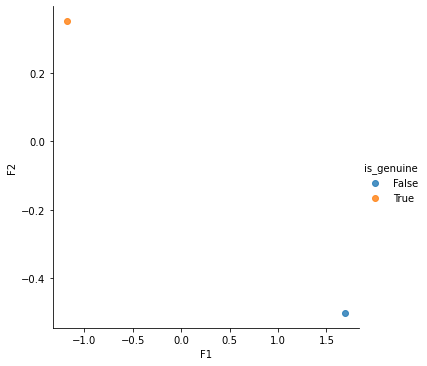

In [41]:
sns.lmplot(x="F1", y="F2", data=cent_data, fit_reg=False, hue='is_genuine')

length / margin low bien differentes

## Ajout des COS2 au tableau de donnees

In [42]:
temp = pd.concat([temp, cos2_indiv], axis=1)
temp.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,F3,F4,COS2_1,COS2_2,COS2_3,COS2_4
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,1.787451,2.433465,0.251929,0.139000,0.173540,0.321649
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039,0.542563,0.344550,0.818002,0.050822,0.054065,0.021803
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102,0.858716,0.374812,0.784862,0.000466,0.148652,0.028320
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105,-0.531529,0.519548,0.882856,0.001652,0.058789,0.056169
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170,3.319507,-0.837043,0.320145,0.009417,0.610831,0.038839


In [43]:
cent_data = temp.groupby(["is_genuine" ]).mean()
cent_data = cent_data.reset_index()
cent_data.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,F3,F4,COS2_1,COS2_2,COS2_3,COS2_4
0,False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714,1.691374,-0.502571,-0.022942,-0.139574,0.496250,0.198254,0.143114,0.080667
1,True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200,-1.183962,0.351800,0.016060,0.097702,0.455141,0.226626,0.142304,0.084800


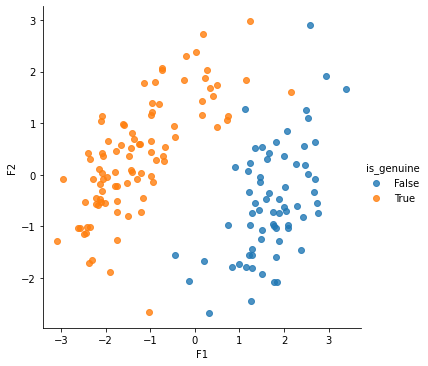

In [44]:
sns.lmplot(x="F1", y="F2", data=temp.loc[(temp['COS2_1']+temp['COS2_2']>=0.30)], fit_reg=False, hue='is_genuine')

## Classification Kmeans

In [45]:
# nombre de cluster
n_clust = 2

# on conserve les colonnes qui nous intéressent
data_km = data[select]

# préparation des données
X = data_km.values

# clustering par Kmeans
km = KMeans(n_clusters=n_clust)
km.fit(X)

# récupération des clusters attribués à chaque individu
clusters = km.labels_

In [46]:
# conversion en data frame
clusters = pd.DataFrame(clusters)
clusters.columns=["cluster"]
clusters.cluster=clusters.cluster+1 # cluster commencent à 1

In [47]:
clusters.head()

,cluster
0,2
1,2
2,2
3,2
4,2


In [48]:
# merge cluster & data_fn
temp_cluster = pd.concat([clusters, data_fn], axis=1)
del temp_cluster["index"]

In [49]:
temp_cluster.head()

,cluster,F1,F2,F3,F4
0,2,2.153639,1.599709,1.787451,2.433465
1,2,-2.110416,-0.526039,0.542563,0.344550
2,2,-1.973152,-0.048102,0.858716,0.374812
3,2,-2.059795,-0.089105,-0.531529,0.519548
4,2,-2.403180,0.412170,3.319507,-0.837043


## Projection individus par clusters selon Kmeans

Text(0.5, 1.0, 'Projection Individus par Clusters - Kmeans')

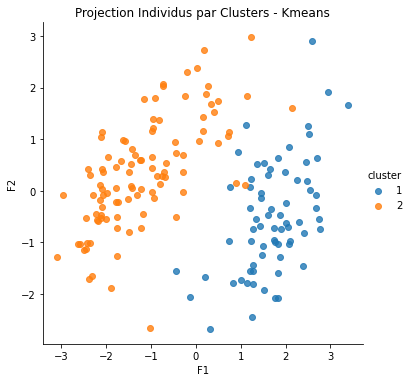

In [50]:
sns.lmplot(x="F1", y="F2", data=temp_cluster, fit_reg=False, hue='cluster')
plt.title("Projection Individus par Clusters - Kmeans")

## Projection centroides par clusters selon Kmeans

In [51]:
# récupération des centroides
cent_km = temp_cluster.groupby(["cluster"]).mean()
cent_km = cent_km.reset_index()
cent_km

,cluster,F1,F2,F3,F4
0,1,1.697931,-0.512546,-0.028115,-0.165013
1,2,-1.159973,0.350155,0.019208,0.112732


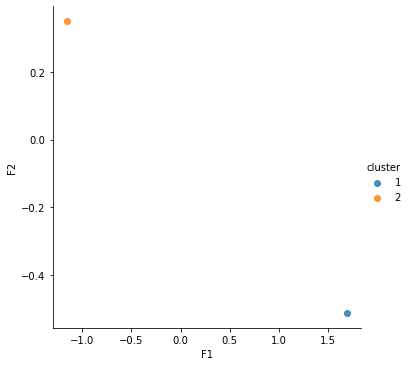

In [52]:
sns.lmplot(x="F1", y="F2", data=cent_km, fit_reg=False, hue='cluster')

## Comparaison centroides ACP vs Kmeans

In [53]:
temp_cent = pd.concat([cent_data[['is_genuine', 'F1', 'F2']], cent_km[['cluster', 'F1', 'F2']]], axis=1)
temp_cent.columns = ['is_genuine', 'F1_acp', 'F2_acp', 'cluster', 'F1_km', 'F2_km']

In [54]:
temp_cent # attention, False ne correspond pas au cluster 1 et True ne correspond pas au cluster 2

,is_genuine,F1_acp,F2_acp,cluster,F1_km,F2_km
0,False,1.691374,-0.502571,1,1.697931,-0.512546
1,True,-1.183962,0.351800,2,-1.159973,0.350155


<AxesSubplot:xlabel='F1_acp', ylabel='F2_acp'>

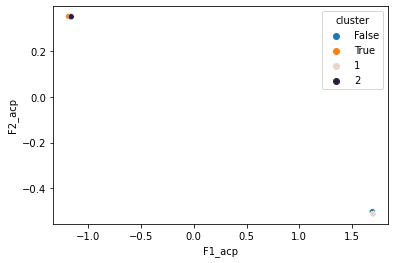

In [55]:
sns.scatterplot(data=temp_cent, x="F1_acp", y="F2_acp", hue='is_genuine')
sns.scatterplot(data=temp_cent, x="F1_km", y="F2_km", hue='cluster')

In [56]:
prop_clust = pd.crosstab(temp['is_genuine'], clusters['cluster'])

In [57]:
prop_clust

cluster,1,2
is_genuine,,
False,68,2
True,1,99


les billets sont bien dissocies, une reel separation

In [58]:
temp.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,F3,F4,COS2_1,COS2_2,COS2_3,COS2_4
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,1.787451,2.433465,0.251929,0.139000,0.173540,0.321649
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039,0.542563,0.344550,0.818002,0.050822,0.054065,0.021803
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102,0.858716,0.374812,0.784862,0.000466,0.148652,0.028320
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105,-0.531529,0.519548,0.882856,0.001652,0.058789,0.056169
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170,3.319507,-0.837043,0.320145,0.009417,0.610831,0.038839
5,True,172.57,104.65,104.44,4.54,2.99,113.16,1.235656,2.983191,0.953054,0.388824,0.132447,0.771985,0.078792,0.013115
6,True,172.38,103.55,103.80,3.97,2.90,113.30,-2.079412,1.147980,0.171245,-0.961222,0.538540,0.164137,0.003652,0.115076
7,True,171.58,103.65,103.37,3.54,3.19,113.38,-2.623934,-1.040133,-1.069093,0.358568,0.736813,0.115779,0.122316,0.013759
8,True,171.96,103.51,103.75,4.06,3.33,113.53,-1.736309,-0.227631,-1.146803,0.063924,0.505695,0.008692,0.220603,0.000685
9,True,172.14,104.34,104.20,4.63,3.02,112.47,0.727490,1.063881,0.704949,0.113244,0.222965,0.476836,0.209362,0.005403


In [59]:
temp = temp.drop(['F3', 'F4'], axis=1)

## Calcul de proportions

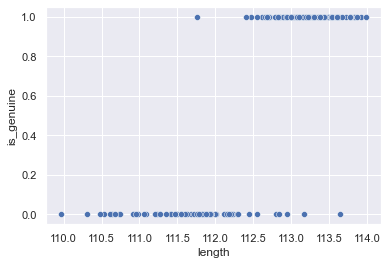

In [60]:
sns.set()
ax = sns.scatterplot(x="length", y="is_genuine", data=temp)

In [61]:
# merge cluster & temp
temp = pd.concat([temp, clusters], axis=1)

In [62]:
temp.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,COS2_1,COS2_2,COS2_3,COS2_4,cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,0.251929,0.139000,0.173540,0.321649,2
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039,0.818002,0.050822,0.054065,0.021803,2
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102,0.784862,0.000466,0.148652,0.028320,2
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105,0.882856,0.001652,0.058789,0.056169,2
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170,0.320145,0.009417,0.610831,0.038839,2


In [63]:
temp['cl_length'] = pd.cut(temp['length'], bins = np.arange(109.97, 113.98, 0.1), right=False)
prop = pd.crosstab(temp['cl_length'], temp['is_genuine'], normalize='index')
prop_genuine = pd.DataFrame(data = {'length': np.concatenate((np.array([temp['length'].min()]), 
                                                np.repeat(np.arange(110.31,113.92,0.22), repeats=2),
                                                np.array([temp['length'].max()])), axis=0),
                                'prop_genuine': np.repeat(prop.loc[:,1].values, repeats=1)})

In [64]:
temp.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,COS2_1,COS2_2,COS2_3,COS2_4,cluster,cl_length
0,True,171.81,104.86,104.95,4.52,2.89,112.83,2.153639,1.599709,0.251929,0.139000,0.173540,0.321649,2,"[112.77, 112.87)"
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-2.110416,-0.526039,0.818002,0.050822,0.054065,0.021803,2,"[113.27, 113.37)"
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-1.973152,-0.048102,0.784862,0.000466,0.148652,0.028320,2,"[113.77, 113.87)"
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-2.059795,-0.089105,0.882856,0.001652,0.058789,0.056169,2,"[113.57, 113.67)"
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-2.403180,0.412170,0.320145,0.009417,0.610831,0.038839,2,"[113.47, 113.57)"


No handles with labels found to put in legend.


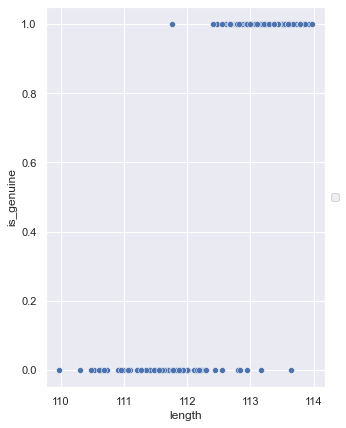

In [65]:
plt.figure(figsize=(5,7))
ax = sns.scatterplot(x='length', y="is_genuine", data=temp)
#plt.plot(prop_genuine['length'], prop_genuine['prop_genuine'], color='black', label='Proportion authenticite')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Regression Logistique 1 -> Sans Margin_up

In [66]:
reg_log1 = smf.glm('is_genuine ~ diagonal+height_left+height_right+margin_low+length',
                   data=temp, family=sm.families.Binomial()).fit()
print(reg_log1.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                  170
Model:                                                   GLM   Df Residuals:                      164
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -4.1324
Date:                                       Wed, 10 Nov 2021   Deviance:                       8.2649
Time:                                               16:05:08   Pearson chi2:                     8.77
No. Iterations:                                           12                                         
Covariance Type:                                   nonrobust                      

In [67]:
reg_log1.predict()

array([3.06939856e-02, 6.36736668e-08, 3.75115468e-08, 1.97643144e-11,
       4.57262002e-03, 9.90772374e-05, 1.23463891e-09, 3.72350795e-11,
       1.92522128e-09, 6.18663183e-01, 2.56774616e-10, 4.29512018e-12,
       4.29350703e-06, 8.89047939e-10, 3.56395721e-10, 3.90108834e-04,
       1.07345741e-08, 1.20227062e-05, 3.27333152e-11, 9.03772731e-08,
       2.00852451e-05, 1.46980501e-07, 1.18868098e-06, 1.41316456e-05,
       2.18069012e-09, 3.94962979e-11, 3.83802209e-09, 3.03802766e-03,
       2.49074082e-11, 1.73647881e-09, 3.11127998e-10, 3.54495823e-08,
       9.78491335e-06, 2.33605958e-04, 3.27446384e-06, 6.36388777e-04,
       5.64623632e-09, 2.42631072e-11, 3.59254298e-09, 8.30706178e-04,
       7.63228081e-07, 2.62290844e-03, 8.23679851e-04, 5.94253408e-02,
       3.43289165e-05, 7.02359796e-07, 1.24501732e-06, 1.18017460e-11,
       2.82188696e-06, 1.05840921e-09, 7.32297977e-08, 2.87484615e-02,
       6.67907924e-06, 1.15183697e-10, 1.41052181e-07, 1.31770582e-05,
      

## Regression Logistique 2 -> Length

In [68]:
reg_log2 = smf.glm('is_genuine ~ length', data=temp, family=sm.families.Binomial()).fit()

print(reg_log2.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                  170
Model:                                                   GLM   Df Residuals:                      168
Model Family:                                       Binomial   Df Model:                            1
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -31.836
Date:                                       Wed, 10 Nov 2021   Deviance:                       63.672
Time:                                               16:05:08   Pearson chi2:                     371.
No. Iterations:                                            7                                         
Covariance Type:                                   nonrobust                      

In [69]:
reg_log2.predict()

array([1.60790545e-01, 1.98862272e-02, 1.38285761e-03, 3.84473428e-03,
       5.67093298e-03, 3.68588356e-02, 1.89568373e-02, 1.29077465e-02,
       6.24882419e-03, 5.26181189e-01, 7.22711498e-03, 1.45192961e-03,
       1.14777673e-01, 1.42125576e-02, 1.11691541e-02, 2.18808376e-02,
       6.55934862e-03, 1.06427360e-02, 2.52442452e-02, 5.67093298e-03,
       5.11042609e-02, 3.68588356e-02, 2.91092719e-02, 3.19987617e-02,
       1.09910818e-01, 9.36238659e-04, 6.98716495e-04, 7.58588276e-03,
       1.35446643e-02, 2.48128772e-03, 6.55934862e-03, 1.76442081e-03,
       3.59271710e-01, 2.56044181e-01, 4.44525292e-02, 6.55934862e-03,
       9.66244685e-03, 3.84473428e-03, 1.85251604e-03, 7.71200080e-02,
       1.19471653e-03, 2.46857697e-01, 2.40705963e-02, 3.05216467e-01,
       2.56044181e-01, 2.64735672e-02, 3.86313391e-02, 4.66980790e-03,
       1.48049873e-01, 4.66980790e-03, 7.37169592e-02, 1.67486421e-01,
       1.81543310e-01, 1.29077465e-02, 4.87885113e-02, 1.01408743e-02,
      

In [70]:
beta1 = reg_log2.params[0]
beta2 = reg_log2.params[1]

In [71]:
x = np.linspace(start=109.97, stop=113.98, num=500)
y = np.exp(beta1+beta2*x)/(1+np.exp(beta1+beta2*x))
y = np.sort(y)
reg_log = pd.DataFrame(data={'length': x, 'prop_genuine': y})

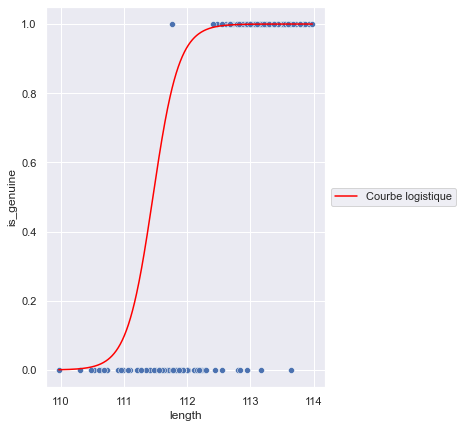

In [72]:
plt.figure(figsize=(5,7))
ax = sns.scatterplot(x='length', y="is_genuine", data=temp)
#plt.plot(prop_genuine['length'], prop_genuine['prop_genuine'], color='black', label='Proportion authenticite')
plt.plot(reg_log['length'], reg_log['prop_genuine'], color='red', label='Courbe logistique')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Tableau de donnees avec taux de prediction pour chqe billet

In [73]:
cols = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
pred_vs_reel = temp[cols]

In [74]:
d_pred = reg_log1.predict()

In [75]:
d_pred = d_pred[::-1]

In [76]:
d_pred = pd.DataFrame(d_pred, columns=['prediction'])

In [77]:
d_pred

,prediction
0,1.000000e+00
1,9.998700e-01
2,1.000000e+00
3,1.000000e+00
4,9.999999e-01
...,...
165,4.572620e-03
166,1.976431e-11
167,3.751155e-08
168,6.367367e-08


In [78]:
pred_vs_reel = pd.concat([pred_vs_reel, d_pred], axis=1)

In [79]:
pred_vs_reel.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,prediction
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1.00000
1,True,171.67,103.74,103.70,4.01,2.87,113.29,0.99987
2,True,171.83,103.76,103.76,4.40,2.88,113.84,1.00000
3,True,171.80,103.78,103.65,3.73,3.12,113.63,1.00000
4,True,172.05,103.70,103.75,5.04,2.27,113.55,1.00000


## Validation croisee Knn

In [80]:
X = data[data.columns[1:]].values
y = data['is_genuine'].values

In [81]:
X.shape

(170, 6)

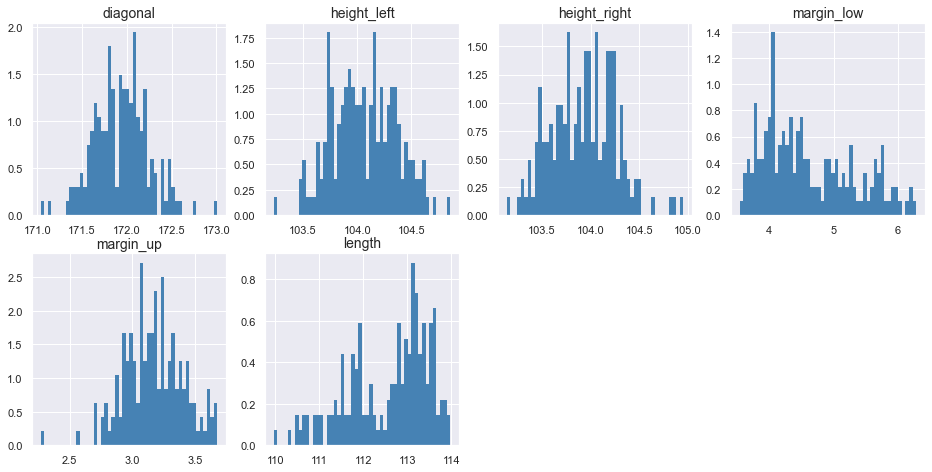

In [82]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx+1], fontsize=14)

In [83]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                    test_size=0.3 # 30% des données dans le jeu de test
                                    )

In [84]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(119, 6) (119,)
(51, 6) (51,)


In [85]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

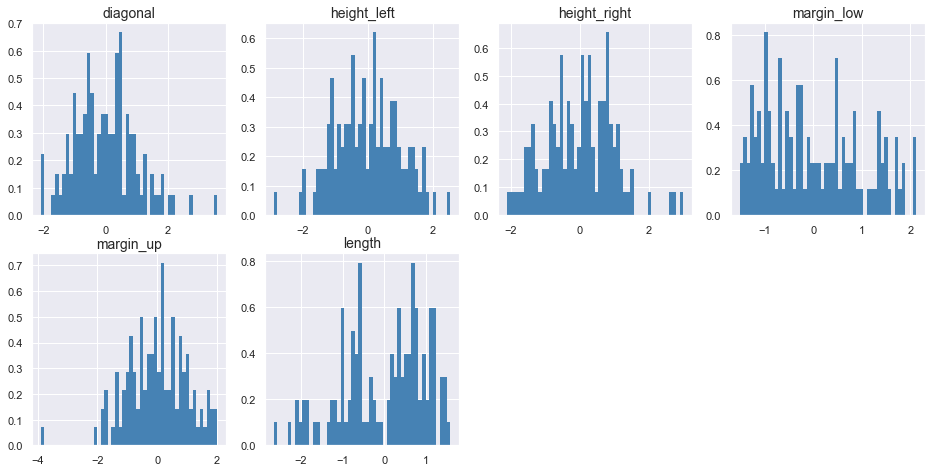

In [86]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx+1], fontsize=14)

In [87]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 3}
Résultats de la validation croisée :
accuracy = 0.983 (+/-0.041) for {'n_neighbors': 3}
accuracy = 0.975 (+/-0.041) for {'n_neighbors': 5}
accuracy = 0.983 (+/-0.041) for {'n_neighbors': 7}
accuracy = 0.975 (+/-0.041) for {'n_neighbors': 9}
accuracy = 0.975 (+/-0.041) for {'n_neighbors': 11}
accuracy = 0.975 (+/-0.041) for {'n_neighbors': 13}
accuracy = 0.975 (+/-0.041) for {'n_neighbors': 15}


In [88]:
y_pred = clf.predict(X_test_std)
print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))


Sur le jeu de test : 1.000


## Modele 1 (complet) / methode 1

### Train Test Split

In [89]:
# défitition variable cible 
y = data["is_genuine"]
# création jeu training et testing avec stratification par y
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, y, test_size=0.3, stratify=y, random_state=0)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(119, 7) (119,)
(51, 7) (51,)


In [90]:
# définition modele
model1 = LogisticRegression(solver='liblinear', random_state=0)

In [91]:
#définition variables 
cols_ = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# ajustement du modele sur données entrainement
model1.fit(X_train[cols_], y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [92]:
print(model1.classes_)
print(model1.intercept_)
print(model1.coef_)

[False  True]
[-0.00568451]
[[-0.12713502 -0.72518762 -1.18631852 -2.3217929  -1.33712106  2.09853817]]


In [93]:
model1.predict_proba(X_train[cols_])

array([[4.76066860e-02, 9.52393314e-01],
       [9.69202715e-01, 3.07972851e-02],
       [9.95094341e-01, 4.90565949e-03],
       [9.03159976e-01, 9.68400243e-02],
       [1.50808876e-01, 8.49191124e-01],
       [2.64195587e-02, 9.73580441e-01],
       [9.72397933e-01, 2.76020666e-02],
       [2.32190408e-02, 9.76780959e-01],
       [1.33304001e-02, 9.86669600e-01],
       [9.70597198e-01, 2.94028019e-02],
       [2.11853866e-02, 9.78814613e-01],
       [9.96004510e-01, 3.99549027e-03],
       [9.58185408e-01, 4.18145918e-02],
       [3.37452728e-01, 6.62547272e-01],
       [4.97746109e-01, 5.02253891e-01],
       [1.31770663e-02, 9.86822934e-01],
       [2.92147367e-03, 9.97078526e-01],
       [9.87356097e-01, 1.26439026e-02],
       [1.25329650e-02, 9.87467035e-01],
       [1.02656665e-02, 9.89734334e-01],
       [1.39171406e-02, 9.86082859e-01],
       [9.37238624e-01, 6.27613760e-02],
       [1.40627003e-02, 9.85937300e-01],
       [2.63983256e-02, 9.73601674e-01],
       [9.853843

In [94]:
model1.score(X_train[cols_], y_train)

0.9831932773109243

In [95]:
metrics.confusion_matrix(y_train, model1.predict(X_train[cols_]))

array([[47,  2],
       [ 0, 70]], dtype=int64)

#### Matrice de confusion facon heatmap

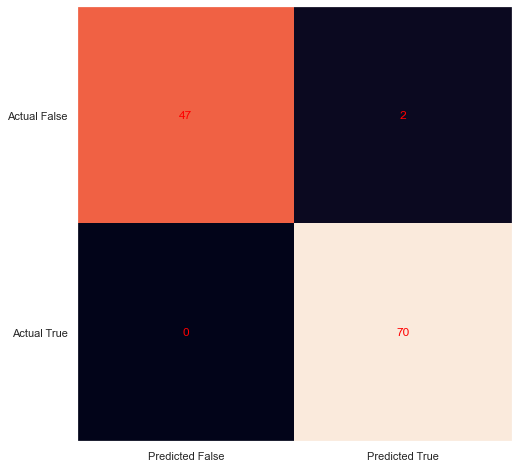

In [96]:
cm1 = metrics.confusion_matrix(y_train, model1.predict(X_train[cols_]))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm1)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted False', 'Predicted True'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual False', 'Actual True'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm1[i, j], ha='center', va='center', color='red')
plt.show()

In [97]:
print(metrics.classification_report(y_train, model1.predict(X_train[cols_])))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98        49
        True       0.97      1.00      0.99        70

    accuracy                           0.98       119
   macro avg       0.99      0.98      0.98       119
weighted avg       0.98      0.98      0.98       119



#### Modele 1 (complet) / methode 2

In [98]:
# défitition variable cible 
y = data["is_genuine"]
# création jeu training et testing avec stratification par y
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, y, test_size=0.3, stratify=y, random_state=0)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(119, 7) (119,)
(51, 7) (51,)


In [99]:
#définition variables 
cols_ = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
# définition modele
model2 = LogisticRegression(solver='liblinear', random_state=0)
model2.fit(X_train[cols_], y_train)

LogisticRegression(random_state=0, solver='liblinear')

#### Matrice de confusion

In [100]:
actual = y_test
predicted2 = model2.predict(X_test[cols_])
cm2 = metrics.confusion_matrix(actual, predicted2) 
print(cm2)
print(metrics.classification_report(actual, predicted2))

[[21  0]
 [ 1 29]]
              precision    recall  f1-score   support

       False       0.95      1.00      0.98        21
        True       1.00      0.97      0.98        30

    accuracy                           0.98        51
   macro avg       0.98      0.98      0.98        51
weighted avg       0.98      0.98      0.98        51



In [101]:
# calcul criteres de performances
total2 = sum(sum(cm2))
accuracy2 = (cm2[0,0]+cm2[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1])
print('Sensitivity : ', sensitivity2 )

specificity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1])
print('Specificity : ', specificity2)

precision2 = metrics.precision_score(actual, predicted2) 
print('Precision : ', precision2)

AUC_2 = metrics.roc_auc_score(actual, predicted2)
print('AUC : ', AUC_2)

Accuracy :  0.9803921568627451
Sensitivity :  1.0
Specificity :  0.9666666666666667
Precision :  1.0
AUC :  0.9833333333333334


In [102]:
metrics.accuracy_score(actual, predicted2)

0.9803921568627451

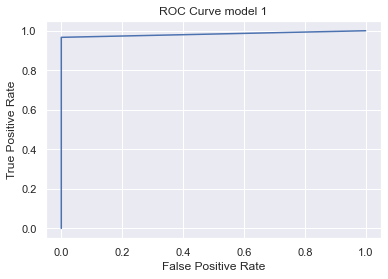

In [103]:
fpr, tpr, thresholds = metrics.roc_curve(actual, predicted2)
plt.plot(fpr, tpr)
plt.title("ROC Curve model 1")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Modele 2 (margin_low + length) / methode 1

In [104]:
# défitition variable cible 
y = data["is_genuine"]
# création jeu training et testing avec stratification par y
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, y, test_size=0.3, stratify=y, random_state=0)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(119, 7) (119,)
(51, 7) (51,)


In [105]:
# définition modele
model3 = LogisticRegression(solver='liblinear', random_state=0)

In [106]:
#définition variables 
cols_ = ['margin_low', 'length']

# ajustement du modele sur données entrainement
model3.fit(X_train[cols_], y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [107]:
print(model3.classes_)
print(model3.intercept_)
print(model3.coef_)

[False  True]
[-0.14099372]
[[-3.60870335  0.15332891]]


In [108]:
model3.predict_proba(X_train[cols_])

array([[0.21235856, 0.78764144],
       [0.89541024, 0.10458976],
       [0.99486622, 0.00513378],
       [0.74693142, 0.25306858],
       [0.62116965, 0.37883035],
       [0.07409253, 0.92590747],
       [0.7490681 , 0.2509319 ],
       [0.01674955, 0.98325045],
       [0.07864926, 0.92135074],
       [0.80462798, 0.19537202],
       [0.07384122, 0.92615878],
       [0.98140313, 0.01859687],
       [0.77895242, 0.22104758],
       [0.29684035, 0.70315965],
       [0.16494852, 0.83505148],
       [0.11507132, 0.88492868],
       [0.01133311, 0.98866689],
       [0.97740704, 0.02259296],
       [0.0300718 , 0.9699282 ],
       [0.0143346 , 0.9856654 ],
       [0.03282908, 0.96717092],
       [0.90682163, 0.09317837],
       [0.05365329, 0.94634671],
       [0.34551711, 0.65448289],
       [0.96734973, 0.03265027],
       [0.17250513, 0.82749487],
       [0.97165605, 0.02834395],
       [0.10593122, 0.89406878],
       [0.94467984, 0.05532016],
       [0.03892135, 0.96107865],
       [0.

In [109]:
model3.score(X_train[cols_], y_train)

0.9411764705882353

In [110]:
metrics.confusion_matrix(y_train, model3.predict(X_train[cols_]))

array([[44,  5],
       [ 2, 68]], dtype=int64)

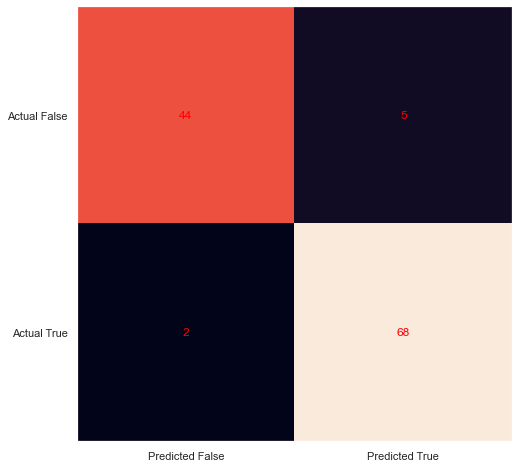

In [111]:
cm3 = metrics.confusion_matrix(y_train, model3.predict(X_train[cols_]))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm3)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted False', 'Predicted True'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual False', 'Actual True'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm3[i, j], ha='center', va='center', color='red')
plt.show()

In [112]:
print(metrics.classification_report(y_train, model3.predict(X_train[cols_])))

              precision    recall  f1-score   support

       False       0.96      0.90      0.93        49
        True       0.93      0.97      0.95        70

    accuracy                           0.94       119
   macro avg       0.94      0.93      0.94       119
weighted avg       0.94      0.94      0.94       119



#### Modele 2 (margin_low + length) / methode 2

In [113]:
# défitition variable cible 
y = data["is_genuine"]
# création jeu training et testing avec stratification par y
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, y, test_size=0.3, stratify=y, random_state=0)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(119, 7) (119,)
(51, 7) (51,)


In [114]:
#définition variables 
cols_ = ['margin_low', 'length']
# définition modele
model4 = LogisticRegression(solver='liblinear', random_state=0)
model4.fit(X_train[cols_], y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [115]:
actual = y_test
predicted4 = model4.predict(X_test[cols_])
cm4 = metrics.confusion_matrix(actual, predicted4) 
print(cm2)
print(metrics.classification_report(actual, predicted4))

[[21  0]
 [ 1 29]]
              precision    recall  f1-score   support

       False       1.00      0.81      0.89        21
        True       0.88      1.00      0.94        30

    accuracy                           0.92        51
   macro avg       0.94      0.90      0.92        51
weighted avg       0.93      0.92      0.92        51



In [116]:
# calcul criteres de performances
total4 = sum(sum(cm4))
accuracy4 = (cm4[0,0]+cm4[1,1])/total4
print ('Accuracy : ', accuracy2)

sensitivity4 = cm4[0,0]/(cm4[0,0]+cm4[0,1])
print('Sensitivity : ', sensitivity4)

specificity4 = cm4[1,1]/(cm4[1,0]+cm4[1,1])
print('Specificity : ', specificity4)

precision4 = metrics.precision_score(actual, predicted4) 
print('Precision : ', precision2)

AUC_4 = metrics.roc_auc_score(actual, predicted4)
print('AUC : ', AUC_4)

Accuracy :  0.9803921568627451
Sensitivity :  0.8095238095238095
Specificity :  1.0
Precision :  1.0
AUC :  0.9047619047619048


In [117]:
metrics.accuracy_score(actual, predicted4)

0.9215686274509803

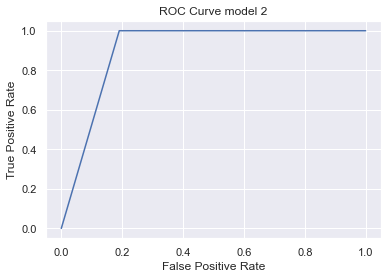

In [118]:
fpr, tpr, thresholds = metrics.roc_curve(actual, predicted4)
plt.plot(fpr, tpr)
plt.title("ROC Curve model 2")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Comparaison des modeles

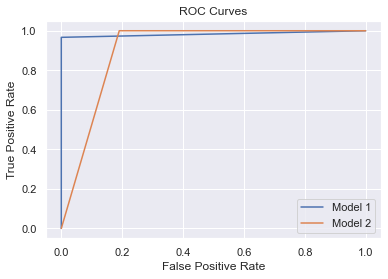

In [119]:
fpr, tpr, thresholds = metrics.roc_curve(actual, predicted2)
plt.plot(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(actual, predicted4)
plt.plot(fpr, tpr)

plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Model 1", "Model 2"])
plt.show()

In [120]:
accuracy_comp = [accuracy2, accuracy4]

sensitivity_comp = [sensitivity2, sensitivity4]

specificity_comp = [specificity2, specificity4]

precision_comp = [precision2, precision4]

auc_comp = [AUC_2, AUC_4]
list_model = ["model1", "model 2"]

var = ["accuracy", "sensitivity", "specificity","precision", "auc"]
model = [list_model]
values = np.array([accuracy_comp,sensitivity_comp, specificity_comp, precision_comp,auc_comp])
model_comp = pd.DataFrame(data=values, index=var, columns=model)
print(model_comp)

               model1   model 2
accuracy     0.980392  0.921569
sensitivity  1.000000  0.809524
specificity  0.966667  1.000000
precision    1.000000  0.882353
auc          0.983333  0.904762
